# Exercise 12: GANs

In [1]:
# Load packages we need
import sys
import os

import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use tensorflow and keras for neural networks
import tensorflow as tf
import tensorflow.keras as keras

# import layers we may use
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, LeakyReLU

# import callbacks we may use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

2024-04-12 07:28:39.357453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 07:28:39.976989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Python version: 3.8.0 (default, Dec  9 2021, 17:53:27) 
[GCC 8.4.0]
### Numpy version: 1.24.3
### Scikit-learn version: 1.3.2
### Tensorflow version: 2.13.1
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### Code to train the GAN

In [3]:
def gan_train_loop(gan, generator, discriminator, train_x, batch_size=200, latent_width=64, alpha=0.25, verbose=False):
       
    discr_loss_avg = 0.0
    gan_loss_avg = 0.0
        
    n = train_x.shape[0]
    num_full_batches = n / batch_size
    batch_idx = 0
    for i in range(0, n, batch_size):
        batch_start_idx = i
        batch_end_idx = np.minimum(n, batch_start_idx+batch_size)
        
        real_data_batch = train_x[batch_start_idx:batch_end_idx]
        
        # 1. train the discriminator for one step       
        # create batch of real & fake data
        eff_batch_size = real_data_batch.shape[0]
        noise_samples = tf.random.normal((eff_batch_size, latent_width), mean=0.0, stddev=1.0)
        fake_data_batch = generator.predict(noise_samples, verbose=0)
        
        # create the labels for these batches (1 -> real, 0 -> fake)
        discr_batch_real = tf.ones((eff_batch_size,), dtype=tf.float32)
        discr_batch_fake = tf.zeros((eff_batch_size,), dtype=tf.float32)
        discr_batch_y = tf.concat([discr_batch_real, discr_batch_fake], axis=0)
        
        # concatenate the two sets
        discr_batch_x = tf.concat([real_data_batch, fake_data_batch], axis=0)
        
        # train the discriminator for one step
        discriminator.trainable = True # make trainable
        discr_loss = discriminator.train_on_batch(discr_batch_x, discr_batch_y)
        
        # moving average for discr_loss
        discr_loss_avg = discr_loss if i==0 else alpha * discr_loss + (1.0 - alpha) * discr_loss_avg
        
        
        # 2. train the generator for one step       
        noise_samples = tf.random.normal([batch_size, latent_width], mean=0.0, stddev=1.0)
                
        # create the labels (pretend these are real images -> label = 1)
        pretend_labels = tf.ones((batch_size,), dtype=tf.float32)
        
        # do one training step
        discriminator.trainable = False # freeze the discriminator
        gan_loss = gan.train_on_batch(noise_samples, pretend_labels)
        
        # moving average for gan_loss
        gan_loss_avg = gan_loss if i==0 else alpha * gan_loss + (1.0 - alpha) * gan_loss_avg
        
        # verbose
        if verbose:
            if batch_start_idx == 0: 
                noise_samples = tf.random.normal([batch_size, latent_width], mean=0.0, stddev=1.0)
                gen_samples = generator.predict(noise_samples, verbose=0)
                min_samples_to_plot = np.minimum(12, batch_size)
                plots.plot_images(gen_samples[0:min_samples_to_plot].reshape(-1, 28, 28), dim_x=28, dim_y=28, one_row=True, fig_size=(12,2))
            
            if np.mod(batch_idx, num_full_batches // 20) == 0:                                      
                sys.stdout.write('.')
                sys.stdout.flush()
            
        batch_idx += 1
        
    if verbose:   
        sys.stdout.write('\n')
        sys.stdout.flush()
        
    return discr_loss_avg, gan_loss_avg

### Load MNIST data.

In [4]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

In [5]:
# renormalize the data so all pixel values are in the [0,1] range 
train_x = train_x / 255.0
test_x = test_x / 255.0
val_x = val_x / 255.0

# reshape   
train_x = train_x.reshape(-1, 28, 28, 1)

### Let's implement a simple GAN architecture

In [6]:
def create_gan(output_dim=28*28, latent_width=64, verbose=False):

    # generator
    gen = keras.models.Sequential(name='Generator')
    
    in_layer = Input(shape=(latent_width,), name='gen-input')
    gen.add(in_layer)
    
    num_units = 7 * 7 * 128
    gen.add(Dense(num_units, name='gen-fc1'))
    gen.add(LeakyReLU(0.2))
    
    gen.add(Reshape((7, 7, 128)))

    # go from 7x7 to 14x14
    gen.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='gen-deconv1'))
    gen.add(LeakyReLU(0.2))
    gen.add(BatchNormalization(name='gen-bn1'))
    
    # go from 14x14 to 28x28
    gen.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name='gen-deconv2'))
    gen.add(LeakyReLU(0.2))
    gen.add(BatchNormalization(name='gen-bn2'))
    
    gen.add(Conv2D(1, (7,7), padding='same', activation='sigmoid', name='gen-output-conv'))


    # discriminator
    discr = keras.models.Sequential(name='Discriminator')
    
    discr.add(Input(shape=[28, 28, 1], name='discr-input'))
    
    discr.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation=LeakyReLU(0.2), name='discr-conv1'))
    discr.add(Dropout(0.3))
    
    discr.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation=LeakyReLU(0.2), name='discr-conv2'))
    discr.add(Dropout(0.3))

    discr.add(Flatten())
    discr.add(Dense(1, activation='sigmoid', name='discr-output'))
  
    # connect the two
    discr_in = gen(in_layer)
    output = discr(discr_in)

    gan = keras.Model(inputs=[in_layer], outputs=[output], name='GAN')
    
    discr.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5))
    discr.trainable = False 
    
    
    # compile
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5))
    
    if verbose:
        gan.summary()
    
    return gan, gen, discr

In [7]:
latent_width = 100

gan, generator, discriminator = create_gan(latent_width=latent_width, verbose=False)

generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen-fc1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 gen-deconv1 (Conv2DTranspo  (None, 14, 14, 128)       262272    
 se)                                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 gen-deconv2 (Conv2DTranspo  (None, 28, 28, 128)       262272    
 se)                                                     

2024-04-12 07:28:41.218488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-12 07:28:41.218539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Puget-190148
2024-04-12 07:28:41.218550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Puget-190148
2024-04-12 07:28:41.218695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 450.102.4
2024-04-12 07:28:41.218727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 450.102.4
2024-04-12 07:28:41.218735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 450.102.4


### Train the GAN

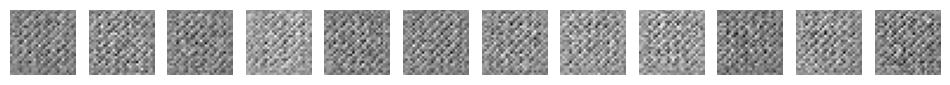

.....................
Epoch 0 - discriminator loss: 0.6427, gan loss: 0.7735


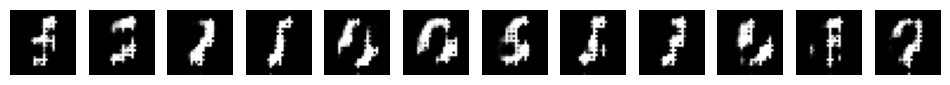

.....................
Epoch 1 - discriminator loss: 0.6888, gan loss: 0.7153


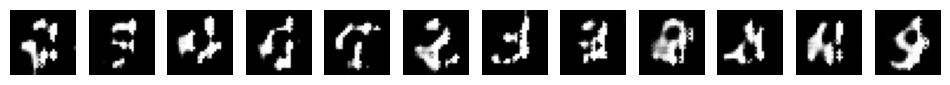

.....................
Epoch 2 - discriminator loss: 0.7174, gan loss: 0.7256


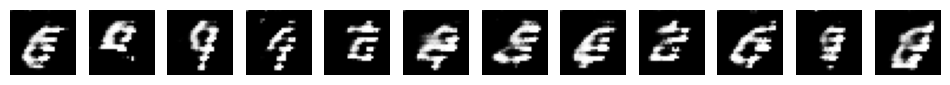

.....................
Epoch 3 - discriminator loss: 0.6837, gan loss: 0.7286


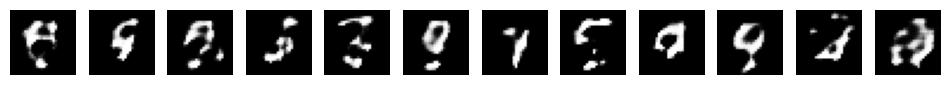

.....................
Epoch 4 - discriminator loss: 0.6866, gan loss: 0.7301


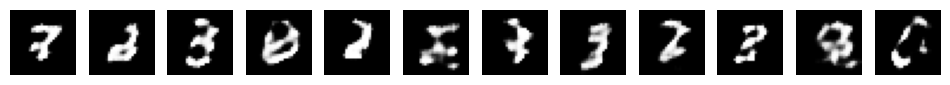

.....................
Epoch 5 - discriminator loss: 0.6760, gan loss: 0.7208


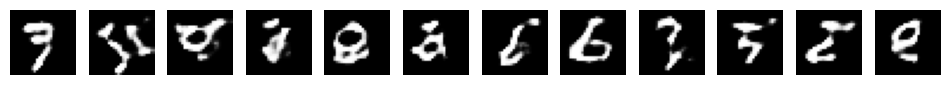

.....................
Epoch 6 - discriminator loss: 0.6959, gan loss: 0.7391


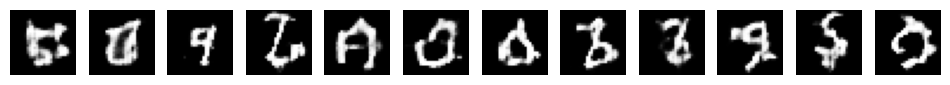

.....................
Epoch 7 - discriminator loss: 0.6829, gan loss: 0.7110


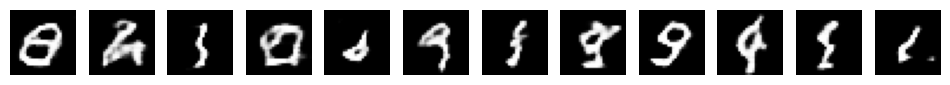

.....................
Epoch 8 - discriminator loss: 0.6783, gan loss: 0.7104


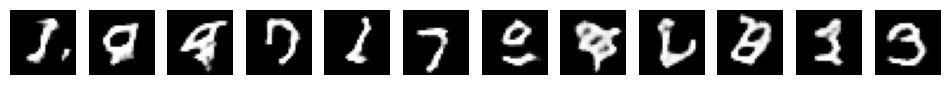

.....................
Epoch 9 - discriminator loss: 0.6791, gan loss: 0.7063


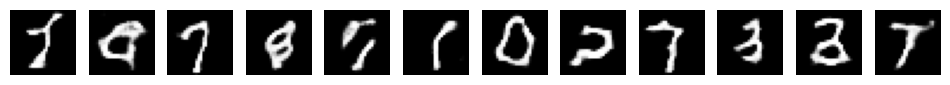

.....................
Epoch 10 - discriminator loss: 0.6859, gan loss: 0.7195


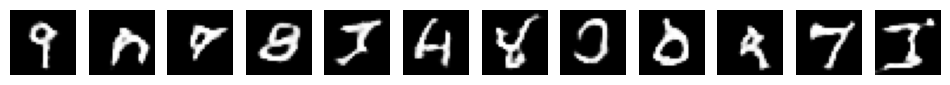

.....................
Epoch 11 - discriminator loss: 0.6849, gan loss: 0.7129


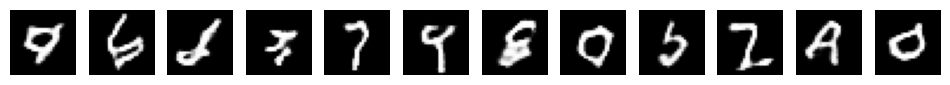

.....................
Epoch 12 - discriminator loss: 0.6842, gan loss: 0.7349


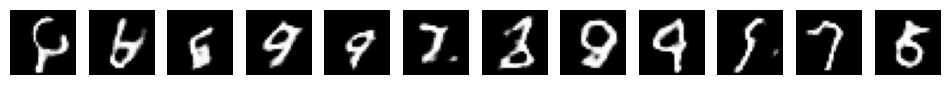

.....................
Epoch 13 - discriminator loss: 0.6834, gan loss: 0.7163


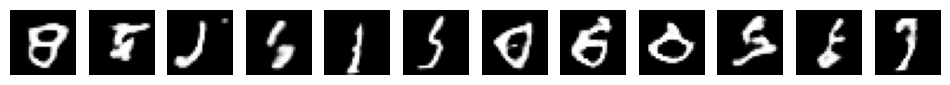

.....................
Epoch 14 - discriminator loss: 0.6855, gan loss: 0.7226


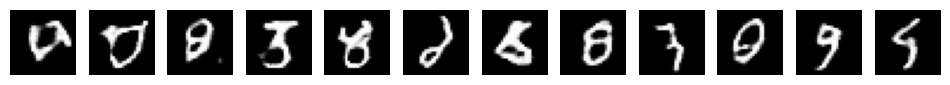

.....................
Epoch 15 - discriminator loss: 0.6839, gan loss: 0.7152


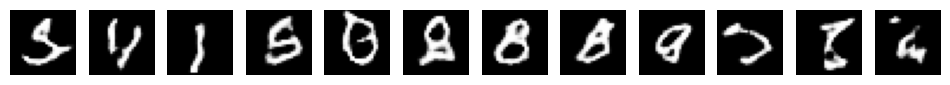

.....................
Epoch 16 - discriminator loss: 0.6902, gan loss: 0.7177


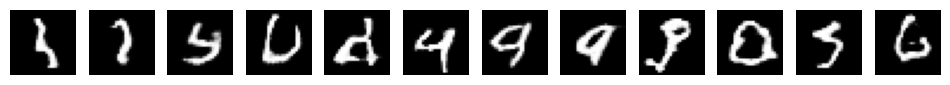

.....................
Epoch 17 - discriminator loss: 0.6813, gan loss: 0.7107


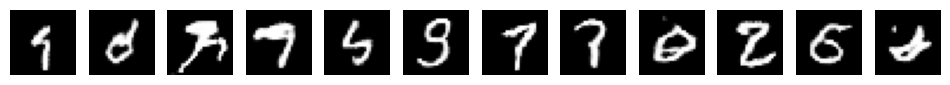

.....................
Epoch 18 - discriminator loss: 0.6849, gan loss: 0.7076


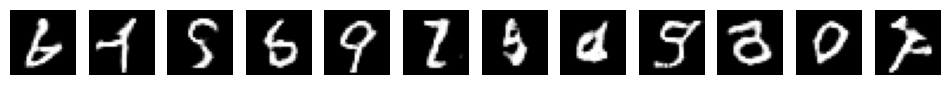

.....................
Epoch 19 - discriminator loss: 0.6852, gan loss: 0.6967


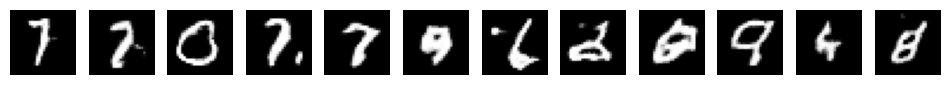

.....................
Epoch 20 - discriminator loss: 0.6877, gan loss: 0.7044


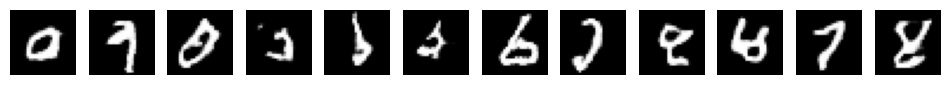

.....................
Epoch 21 - discriminator loss: 0.6828, gan loss: 0.7191


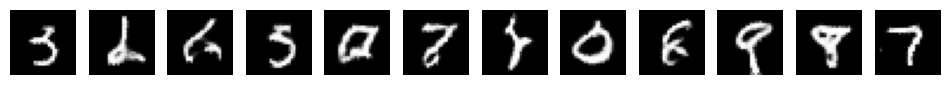

.....................
Epoch 22 - discriminator loss: 0.6881, gan loss: 0.7137


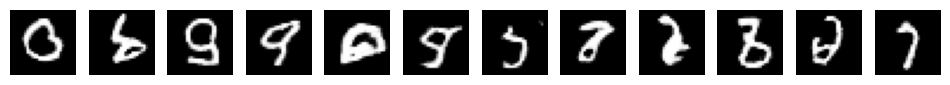

.....................
Epoch 23 - discriminator loss: 0.6839, gan loss: 0.7238


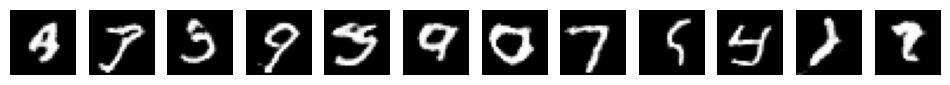

.....................
Epoch 24 - discriminator loss: 0.6855, gan loss: 0.7066


INFO:tensorflow:Assets written to: ./gen.tf/assets


INFO:tensorflow:Assets written to: ./gen.tf/assets


In [8]:
generator_fp = './gen.tf'

#train = False
train = True

if train:
    num_epochs = 25
    batch_size = 192

    for i in range(num_epochs):
        discr_loss_avg, gan_loss_avg = gan_train_loop(gan, generator, discriminator, train_x, 
                                                      batch_size=batch_size, latent_width=latent_width, verbose=True)

        print('Epoch {} - discriminator loss: {:.4f}, gan loss: {:.4f}'.format(i, discr_loss_avg, gan_loss_avg))
        
    generator.save(generator_fp)
else:
    gen = keras.models.load_model(generator_fp)

### Generate new instances

In [9]:
noise_samples = tf.random.normal((100, latent_width), mean=0.0, stddev=1.0)
gen_samples = generator.predict(noise_samples)

4/4 [==============================] - 0s 18ms/step


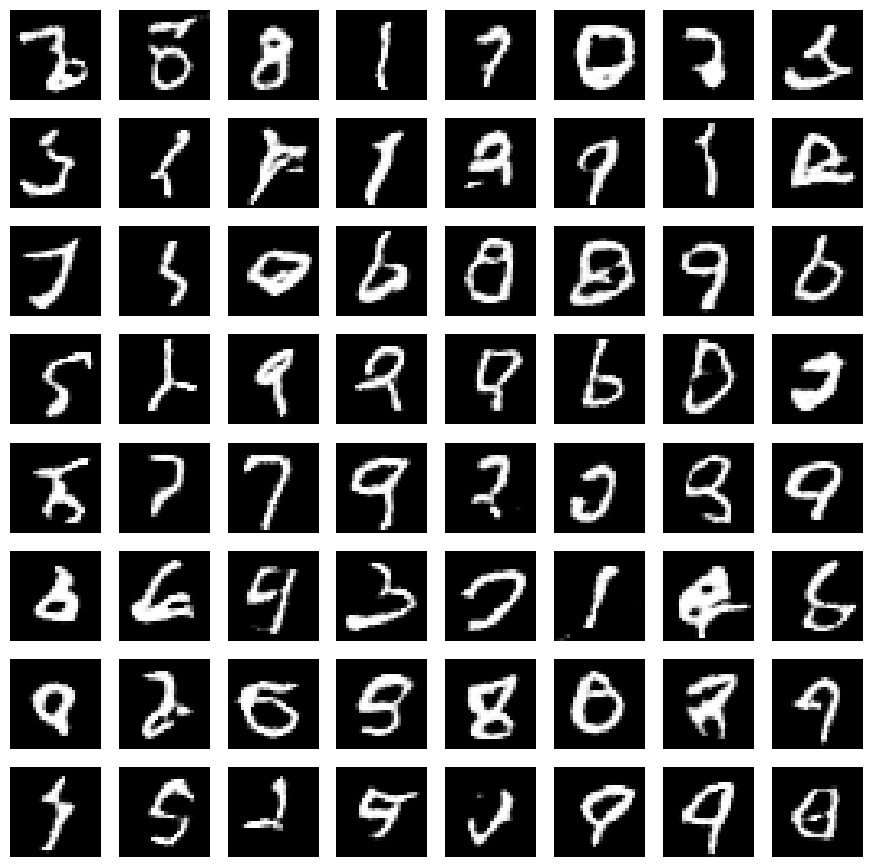

In [10]:
plots.plot_images(gen_samples[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))